In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from sklearn.model_selection import train_test_split
import mlflow

In [10]:
# hyperparameters
# NUM_EPOCHS = 25
NUM_EPOCHS = 12 # new, converged in this time
BATCH_SIZE = 4
LAYERS_TRAINED = 1

# use balanced torch imagefolder dataset
fraction = 0.33
experiment = 'upperlower'
target_num_of_classes = 2

# add seconds to run training to mlflow!
runtime = 0

In [11]:
data_transforms = {
    'train': transforms.Compose([
        # transforms.Grayscale(3),
        # transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
        # transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transforms.Grayscale(3),
        transforms.GaussianBlur(3),
        transforms.ColorJitter(brightness=[0.95,1.05], contrast=[0.8,1.2]),
        transforms.RandomAffine(degrees=[-5,5], shear=(1,10,1,10), fill=255),
        transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.2, 0.2, 0.2])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(3),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #old
        transforms.Normalize([0.5, 0.5, 0.5], [0.2, 0.2, 0.2]) #new
    ]),
}


data_dir = f'/home/riikoro/fossil_data/tooth_samples/torch_imagefolder_2/{experiment}'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names

['lower', 'upper']

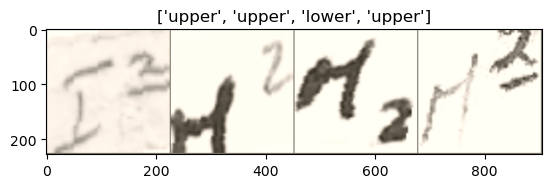

In [12]:

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

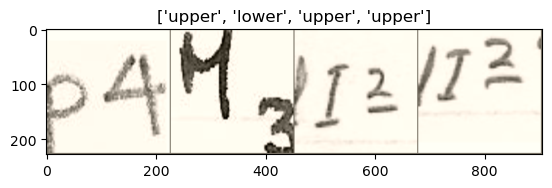

In [13]:
# Get a batch of test data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [14]:
# model_conv = torchvision.models.vit_b_16(weights='DEFAULT')
model_conv = torchvision.models.alexnet(weights='DEFAULT')
for param in list(model_conv.parameters())[:-1*LAYERS_TRAINED]:
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
#alexnet
num_ftrs = model_conv.classifier[6].in_features
model_conv.classifier[6] = nn.Linear(num_ftrs, target_num_of_classes)
# num_ftrs = model_conv.heads[0].in_features
# model_conv.heads[0] = nn.Linear(num_ftrs, target_num_of_classes)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
# vit 
# optimizer_conv = optim.SGD(model_conv.heads[0].parameters(), lr=0.001, momentum=0.9)
optimizer_conv = optim.SGD(model_conv.classifier[6].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

for param in model_conv.parameters():
    print(param.requires_grad)
model_conv

False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_train_acc = 0.0
    best_test_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'test':
                best_test_acc = epoch_acc.item()
            if phase == 'train':
                best_train_acc = epoch_acc.item()

        print()

    print(f'Best val Acc: {best_test_acc:4f}')

    return model, best_train_acc, best_test_acc

In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [17]:
model_conv, train_acc, test_acc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=NUM_EPOCHS)

Epoch 0/11
----------


train Loss: 1.7913 Acc: 0.6197
test Loss: 5.5153 Acc: 0.4000

Epoch 1/11
----------
train Loss: 3.0055 Acc: 0.6873
test Loss: 0.5532 Acc: 0.9000

Epoch 2/11
----------
train Loss: 1.2336 Acc: 0.8085
test Loss: 0.8760 Acc: 0.8000

Epoch 3/11
----------
train Loss: 1.3381 Acc: 0.7746
test Loss: 0.3499 Acc: 0.9250

Epoch 4/11
----------
train Loss: 2.0119 Acc: 0.7634
test Loss: 1.4663 Acc: 0.7500

Epoch 5/11
----------
train Loss: 0.9414 Acc: 0.8648
test Loss: 0.4298 Acc: 0.9000

Epoch 6/11
----------
train Loss: 0.8221 Acc: 0.8423
test Loss: 0.2672 Acc: 0.9750

Epoch 7/11
----------
train Loss: 0.7819 Acc: 0.8507
test Loss: 0.1990 Acc: 0.9500

Epoch 8/11
----------
train Loss: 0.6305 Acc: 0.8789
test Loss: 0.1911 Acc: 0.9500

Epoch 9/11
----------
train Loss: 0.5238 Acc: 0.8761
test Loss: 0.2592 Acc: 0.9750

Epoch 10/11
----------
train Loss: 0.5755 Acc: 0.8648
test Loss: 0.1975 Acc: 0.9500

Epoch 11/11
----------
train Loss: 0.3347 Acc: 0.9127
test Loss: 0.1996 Acc: 0.9500

Best val Acc

In [18]:
print(test_acc)

0.95


In [19]:
print(train_acc)

0.9126760563380282


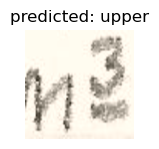

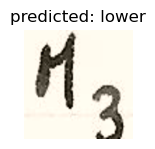

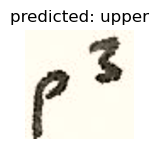

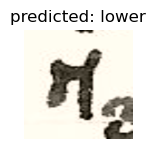

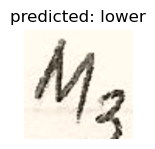

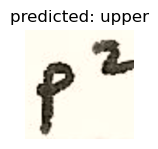

In [20]:

visualize_model(model_conv)

plt.ioff()
plt.show()

In [21]:
model_pt_filename = f'{experiment}.pt'
torch.save(model_conv, model_pt_filename)

In [22]:
%env MLFLOW_TRACKING_URI=sqlite:///../../mlflow.db
mlflow.set_experiment(experiment)

params = {
    'data_v': [3,4,5],
    'train_size': dataset_sizes['train'],
    'test_size': dataset_sizes['test'],
    'batch_size': BATCH_SIZE,
    'num_epochs': NUM_EPOCHS,
    'base_model_path': 'torchvision.models.vit_v_16',
    'preprocessing': 'grayscaling, normalization, random crop',
    'layers_trained': LAYERS_TRAINED
}

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("most frequent class occurence fraction", fraction)
    mlflow.log_metric("training accuracy", train_acc)
    mlflow.log_metric("test accuracy", test_acc)

    mlflow.log_artifact(model_pt_filename)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("info", "AlexNet, added rotation shear and intensity changes to augmentation")

env: MLFLOW_TRACKING_URI=sqlite:///../../mlflow.db
